In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pathlib
from copy import deepcopy
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder


ROOT = pathlib.Path().resolve().parent
sys.path.append(str(ROOT))
from src.config import CONFIG, DEPLOYMENT_CONFIG

# Persian Visualization Fixes
try:
    import arabic_reshaper
    from bidi.algorithm import get_display
except ImportError:
    print("⚠️ Warning: 'arabic-reshaper' or 'python-bidi' not installed. Persian plots might look wrong.")

train = pd.read_csv(CONFIG['data_path'])

In [2]:
#  ---------------------------------------------------------
# 1 . PREPROCESSING FUNCTIONS
#  ---------------------------------------------------------


import joblib
persian_stopwords = joblib.load(CONFIG['stopwords_path'])


from parsivar import Normalizer, Tokenizer
import string

normalizer = Normalizer()
my_tokenizer = Tokenizer()

def preprocessor(input):
    punc_removed = input.translate(str.maketrans('', '', string.punctuation))
    normalized = normalizer.normalize(punc_removed)
    tokens = my_tokenizer.tokenize_sentences(normalized)
    filtered = []
    for token in tokens:
        token = str(token)
        token = token.lower()
        if not token in persian_stopwords and not token.isdigit():
            filtered.append(token)
    output = ' '.join(filtered)
    return output

def tokenizer(text):
    return my_tokenizer.tokenize_words(text)

In [3]:
# ---------------------------------------------------------
# 2.0 DATA CLEANING: MERGING RARE CLASSES
# ---------------------------------------------------------
# Industry Insight: Categories with <50 samples confuse the model.
# We merge them into logical parent categories.
print("🔍 Category distribution before merging rare classes:")
print(train['category'].value_counts().sort_values(ascending=True).head(5))
# Define a mapping dictionary
merge_map = {
    'خانواده': 'اجتماعی',         # Family -> Social
    'اشتغال': 'تجارت و اقتصاد',   # Employment -> Business/Economy
    'علم و دانش': 'تکنولوژی و کامپبوتر', # Science -> Tech
    'حیوانات خانگی': 'اجتماعی'    # Pets -> Social
}

# Apply the mapping
train['category'] = train['category'].replace(merge_map)

print("✅ Rare categories merged to improve model stability.")
print(train['category'].value_counts().sort_values(ascending=True).head(5))

🔍 Category distribution before merging rare classes:
category
حیوانات خانگی    29
علم و دانش       34
خانواده          34
اشتغال           47
تحصیلات          79
Name: count, dtype: int64
✅ Rare categories merged to improve model stability.
category
تحصیلات            79
کتاب و ادبیات      83
مد و زیبایی       118
خانه و باغبانی    128
مسکن              131
Name: count, dtype: int64


In [4]:
# ---------------------------------------------------------
# 2.1 DATA LOADING & PREPARATION
# ---------------------------------------------------------
# Assuming 'train' is your original dataframe loaded previously
df = train.copy()

# Fill NaNs to avoid concatenation errors
text_cols = ['title', 'description', 'text_content', 'h1', 'h2', 'domain']
for col in text_cols:
    df[col] = df[col].fillna('')

# Encode Target
encoder = LabelEncoder()
y_all = encoder.fit_transform(df['category'])

# Define Experiment Feature Sets
experiments = {
    "Baseline (Title Only)": ['title'],
    "Metadata (Title + Desc + Domain)": ['title', 'description', 'domain'],
    "Full Context (All Columns)": ['title', 'description', 'text_content', 'h1', 'h2', 'domain']
}

# Create the HELD-OUT Test Set (10%)
# We will NOT use this index during the loop.
df_dev, df_test, y_dev, y_test = train_test_split(
    df, y_all, 
    test_size=CONFIG['test_size'], 
    random_state=CONFIG['random_state'], 
    stratify=y_all
)

print(f"Train/Dev Size: {len(df_dev)}")
print(f"Held-Out Test Size: {len(df_test)} (Locked 🔒)")

Train/Dev Size: 4310
Held-Out Test Size: 479 (Locked 🔒)


In [5]:
# ---------------------------------------------------------
# 3. ADVANCED TRAINING LOOP (Cross-Validation)
# ---------------------------------------------------------
import warnings

# Silence the specific tokenizer warning to keep output clean
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.feature_extraction.text')

print(f"\n{'Experiment Name':<35} | {'Mean CV F1 (Weighted)':<20} | {'Std Dev':<10}")
print("-" * 75)

best_score = 0
best_model = None
best_pipeline_name = ""

# Variables to hold data for the Visualization step (Safe from leakage)
X_val_best = None
y_val_best = None
model_for_viz = None

for name, cols in experiments.items():
    # A. Feature Engineering
    X_dev_str = df_dev[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    
    # B. Define Pipeline
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenizer, preprocessor=preprocessor, 
                                 min_df=CONFIG['min_df'], 
                                 max_df=CONFIG['max_df'],
                                 ngram_range=CONFIG['ngram_range'])), 
        ('tfidf', TfidfTransformer(sublinear_tf=True)),
        ('clf', LinearSVC(class_weight='balanced', C=CONFIG['model_C'], max_iter=10000))
    ])

    # C. 5-Fold Stratified CV
    cv = StratifiedKFold(n_splits=CONFIG['n_folds'], shuffle=True, random_state=CONFIG['random_state'])
    cv_scores = cross_val_score(pipeline, X_dev_str, y_dev, cv=cv, scoring='f1_weighted', n_jobs=-1)
    avg_score = cv_scores.mean()
    
    print(f"{name:<35} | {avg_score:.4f}               | +/-{cv_scores.std():.4f}")
    
    # D. Save Winner & Prepare Visualization Data (LEAKAGE FREE METHOD)
    if avg_score > best_score:
        best_score = avg_score
        best_pipeline_name = name
        
        # 1. Refit the MAIN model on the FULL Dev set (For final production use)
        pipeline.fit(X_dev_str, y_dev)
        best_model = deepcopy(pipeline)
        
        # 2. Create a temporary split solely for the Confusion Matrix (So it's not 99% acc)
        X_train_viz, X_val_viz, y_train_viz, y_val_viz = train_test_split(
            X_dev_str, y_dev, test_size=0.2, random_state=CONFIG['random_state'], stratify=y_dev
        )
        
        # Train a temporary instance just for the plot
        viz_pipeline = deepcopy(pipeline) 
        viz_pipeline.fit(X_train_viz, y_train_viz)
        
        model_for_viz = viz_pipeline
        X_val_best = X_val_viz
        y_val_best = y_val_viz

print("-" * 75)
print(f"🏆 WINNER: {best_pipeline_name} with F1: {best_score:.4f}")


Experiment Name                     | Mean CV F1 (Weighted) | Std Dev   
---------------------------------------------------------------------------
Baseline (Title Only)               | 0.7286               | +/-0.0140
Metadata (Title + Desc + Domain)    | 0.8094               | +/-0.0066
Full Context (All Columns)          | 0.8010               | +/-0.0168
---------------------------------------------------------------------------
🏆 WINNER: Metadata (Title + Desc + Domain) with F1: 0.8094



📊 Classification Report (Validation Split):
                     precision    recall  f1-score   support

            اجتماعی       0.54      0.65      0.59        49
     تجارت و اقتصاد       0.68      0.76      0.72        59
            تحصیلات       0.64      0.50      0.56        14
تکنولوژی و کامپبوتر       0.80      0.69      0.74        58
حقوق و دولت و سیاست       0.86      0.76      0.80        87
     خانه و باغبانی       0.58      0.65      0.61        23
              خودرو       0.89      0.77      0.82        43
      سفر و گردشگری       0.84      0.82      0.83        33
              سلامت       0.88      0.89      0.88       110
      غذا و نوشیدنی       0.79      0.84      0.81        31
       فیلم و سینما       0.93      0.86      0.89        43
        مد و زیبایی       0.65      0.62      0.63        21
              مذهبی       0.69      0.76      0.72        29
               مسکن       0.84      0.91      0.88        23
             موسیقی       0.98      0.9

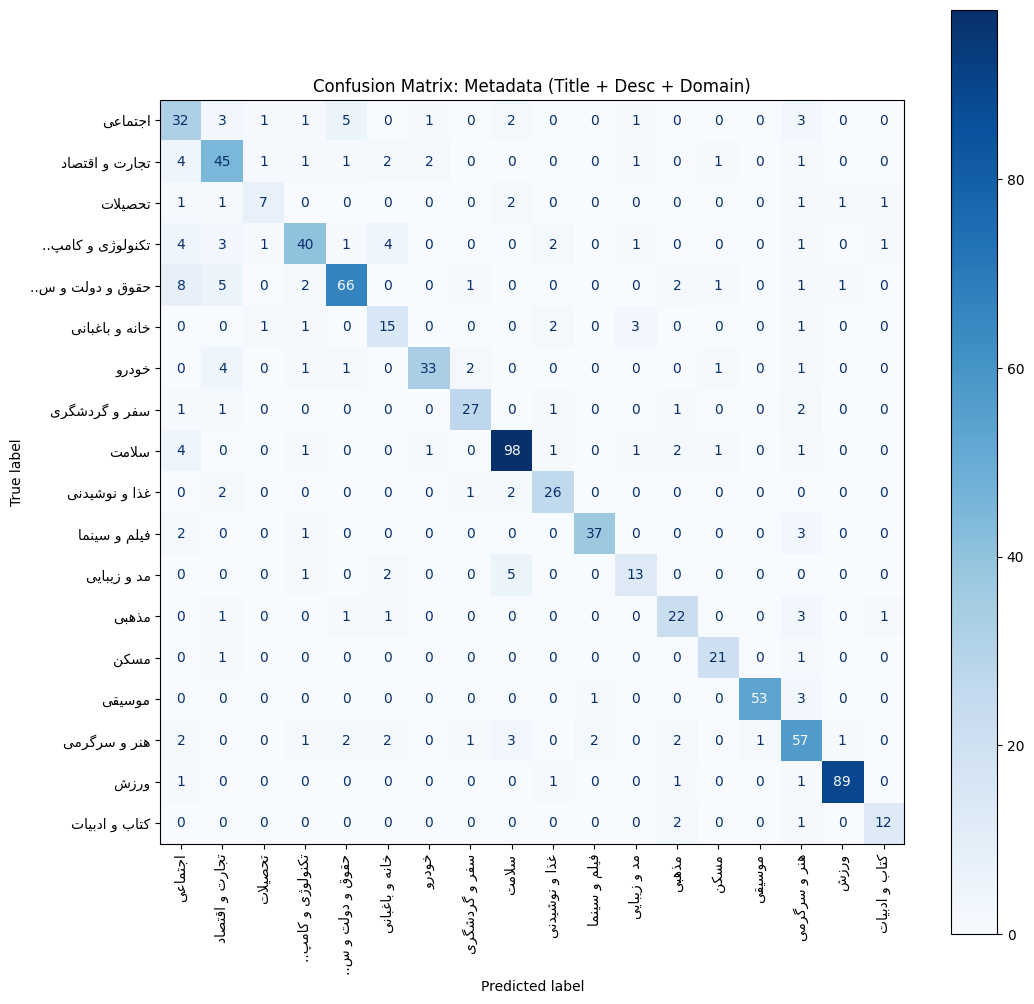

✅ Confusion Matrix saved to C:\Users\amirhadi\Desktop\quera projects\machine learninng projcets\text_categorization\figures\confusion_matrix.png

🧐 Error Analysis: Worst Failures


,True Label,Predicted,Content
0,هنر و سرگرمی,ورزش,ببینید | فرود دیدنی یک جنگنده از نمایی فوق الع...
1,تحصیلات,کتاب و ادبیات,pdf کتاب زیست شناسی جامع پینوکیو جلد دوم خیلی ...
2,حقوق و دولت و سیاست,اجتماعی,ورود یک نماینده با اسب به کنگره +فیلم آلیریو ب...
3,خودرو,تجارت و اقتصاد,آخرین خبر | پراید دوباره جنجال ساز شد آخرین خ...
4,تحصیلات,هنر و سرگرمی,چیز های اعصاب خورد کن در کلاس آنلاین سلام \nلا...
5,کتاب و ادبیات,مذهبی,رمان خدمتکار اجباری من | ❤️یک نت آنچه قرار است...
6,سلامت,اجتماعی,آخرین خبر | آنفلوآنزا اپیدمی شد؛ دو ماه زودتر...
7,سلامت,مسکن,آزمایشگاه‌ های تهران | دریافت جواب آزمایش آزما...
8,هنر و سرگرمی,فیلم و سینما,خواستگاری ویشکا آسایش از مرد مورد علاقه اش | ا...
9,غذا و نوشیدنی,سفر و گردشگری,بهترین غذاهای آرژانتین که باید امتحان کنید - ...


In [6]:
# ---------------------------------------------------------
# 4. VISUALIZATION & INSIGHTS
# ---------------------------------------------------------

def reshape_persian_text(text):
    """Fixes Persian/Arabic text display for Matplotlib"""
    try:
        reshaped_text = arabic_reshaper.reshape(text)
        return get_display(reshaped_text)
    except:
        return text

# A. Classification Report (Using the non-leaking Viz data)
print("\n📊 Classification Report (Validation Split):")
# Note: We use model_for_viz here, which was trained on only 80% of dev
val_preds = model_for_viz.predict(X_val_best) 
print(classification_report(y_val_best, val_preds, target_names=encoder.classes_))

# B. Corrected Confusion Matrix
print("Generating Confusion Matrix...")
fig, ax = plt.subplots(figsize=(12, 12))

# TRUNCATE Labels to 15 chars to fix alignment issues
clean_labels = [label[:15] + '..' if len(label) > 15 else label for label in encoder.classes_]
reshaped_labels = [reshape_persian_text(label) for label in clean_labels]

ConfusionMatrixDisplay.from_estimator(
    model_for_viz, X_val_best, y_val_best,
    display_labels=reshaped_labels,
    xticks_rotation='vertical',
    ax=ax, cmap='Blues',
    values_format='d'
)
plt.title(reshape_persian_text(f"Confusion Matrix: {best_pipeline_name}"))
plt.show()

# ADD this to the end of Cell 30 (after plt.show()):

# Save the confusion matrix to disk for the README
fig.savefig(CONFIG['figure_path'], dpi=300, bbox_inches='tight')
print(f"✅ Confusion Matrix saved to {CONFIG['figure_path']}")

# C. Error Analysis (The "DataFrame" Fix)
print("\n🧐 Error Analysis: Worst Failures")

error_data = []
# Convert X_val_best to list if it's a Series, to index correctly
X_val_list = X_val_best.tolist()

for i, (true_y, pred_y) in enumerate(zip(y_val_best, val_preds)):
    if true_y != pred_y:
        true_label = encoder.inverse_transform([true_y])[0]
        pred_label = encoder.inverse_transform([pred_y])[0]
        
        # Clean the text slightly for display
        full_text = X_val_list[i]
        
        error_data.append({
            "True Label": true_label,
            "Predicted": pred_label,
            "Content": full_text  # Pandas will handle the length
        })
        
    if len(error_data) >= 10:  # Show top 10 errors
        break

# Display as a clean Pandas DataFrame
error_df = pd.DataFrame(error_data)
# Optional: specific styling if you want to force left-alignment or wrapping
# error_df.style.set_properties(**{'text-align': 'right'}) 
display(error_df)   

In [7]:
# ---------------------------------------------------------
# 5. FINAL VALIDATION & PRODUCTION ARTIFACTS
# ---------------------------------------------------------

# A. Score on Held-Out Test Set (The Final Exam)
# We must apply the SAME feature combination as the winner
winner_cols = experiments[best_pipeline_name]
X_test_str = df_test[winner_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
final_preds = best_model.predict(X_test_str)
final_f1 = f1_score(y_test, final_preds, average='weighted')
print(f"🚀 FINAL TEST F1: {final_f1:.4f}")
print("="*40)

# B. Save the Model
# We save the pipeline AND the label encoder (needed to decode predictions)
# B. Save the Model with Enhanced Metadata
from datetime import datetime


artifact = {
    'pipeline': best_model,
    'encoder': encoder,
    'config': CONFIG,
    'deployment_config': DEPLOYMENT_CONFIG,
    'features': winner_cols,
    'metadata': {
        'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'train_samples': len(df_dev),
        'test_samples': len(df_test),
        'cv_mean_f1': best_score,
        'cv_std_f1': cv_scores.std(),
        'final_test_f1': final_f1,
        'num_categories': len(encoder.classes_),
        'feature_combination': best_pipeline_name
    }
}

joblib.dump(artifact, CONFIG['save_path'])
model_size_kb = os.path.getsize(CONFIG['save_path']) / 1024
print(f"\n💾 Model saved to {CONFIG['save_path']}")
print(f"📦 Artifact includes: pipeline, encoder, config, metadata")
print(f"🏷️ Model Version: {DEPLOYMENT_CONFIG['model_version']}")
print(f"📏 Model Size: {model_size_kb:.1f} KB")

# C. Inference Function Example
def predict_category_production(new_text_data, return_confidence=True):
    """
    Production inference with confidence scoring and fallback logic.
    
    Args:
        new_text_data: Dict with article fields (e.g., {'title': '...', 'description': '...'})
        return_confidence: Whether to include prediction confidence
    
    Returns:
        dict: {
            'category': str,
            'confidence': float,
            'needs_review': bool,
            'model_version': str
        }
    
    Example:
        >>> result = predict_category_production({'title': 'پیروزی تیم فوتبال', 'description': 'مسابقات لیگ'})
        >>> print(result)
        {'category': 'ورزش', 'confidence': 0.92, 'needs_review': False, 'model_version': 'v1.2_prod'}
    """
    import numpy as np
    
    # Load model artifacts
    loaded_artifact = joblib.load(CONFIG['save_path'])
    model = loaded_artifact['pipeline']
    enc = loaded_artifact['encoder']
    feats = loaded_artifact['features']
    
    # Combine features (handle missing keys gracefully)
    content = " ".join([str(new_text_data.get(f, '')) for f in feats])
    
    # Get prediction and decision scores
    pred_idx = model.predict([content])[0]
    decision_scores = model.decision_function([content])[0]
    
    # Convert to pseudo-probability using softmax
    exp_scores = np.exp(decision_scores - np.max(decision_scores))  # Numerical stability
    confidence = exp_scores[pred_idx] / exp_scores.sum()
    
    category = enc.inverse_transform([pred_idx])[0]
    
    # Apply business logic for low-confidence predictions
    needs_review = confidence < DEPLOYMENT_CONFIG['min_confidence_threshold']
    if needs_review:
        print(f"⚠️ Low confidence ({confidence:.2f}), falling back to: {DEPLOYMENT_CONFIG['fallback_category']}")
        category = DEPLOYMENT_CONFIG['fallback_category']
    
    if return_confidence:
        return {
            'category': category,
            'confidence': float(confidence),
            'needs_review': needs_review,
            'model_version': DEPLOYMENT_CONFIG['model_version'],
            'all_scores': {enc.classes_[i]: float(exp_scores[i] / exp_scores.sum()) 
                          for i in range(len(enc.classes_))}  # Top-3 for debugging
        }
    return category

# Example Usage
print(f"\nInference Test: {predict_category_production({'title': 'پیروزی تیم فوتبال پرسپولیس', 'description': 'مسابقات لیگ برتر'})}")

🚀 FINAL TEST F1: 0.8005

💾 Model saved to C:\Users\amirhadi\Desktop\quera projects\machine learninng projcets\text_categorization\models\persian_classifier_v1.pkl
📦 Artifact includes: pipeline, encoder, config, metadata
🏷️ Model Version: v1.2_prod
📏 Model Size: 2911.8 KB

Inference Test: {'category': 'ورزش', 'confidence': 0.6629979890595866, 'needs_review': False, 'model_version': 'v1.2_prod', 'all_scores': {'اجتماعی': 0.015042004032805062, 'تجارت و اقتصاد': 0.018137537887349606, 'تحصیلات': 0.019402601872350902, 'تکنولوژی و کامپبوتر': 0.017489860839972782, 'حقوق و دولت و سیاست': 0.01260104138458649, 'خانه و باغبانی': 0.021255653165209946, 'خودرو': 0.021776967865763372, 'سفر و گردشگری': 0.019198955196336742, 'سلامت': 0.02144063487415329, 'غذا و نوشیدنی': 0.0227846701398004, 'فیلم و سینما': 0.019532398471757757, 'مد و زیبایی': 0.022070992540297457, 'مذهبی': 0.01829118775855576, 'مسکن': 0.022672349674065104, 'موسیقی': 0.023811490104106086, 'هنر و سرگرمی': 0.017880011709100595, 'ورزش': 0.6

In [8]:
# ---------------------------------------------------------
# D. ACTIONABLE INSIGHTS & PRODUCTION READINESS
# ---------------------------------------------------------

print("\n" + "="*60)
print("🔍 ACTIONABLE INSIGHTS FROM ERROR ANALYSIS")
print("="*60)

# 1. Analyze Top Confusion Pairs
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_val_best, val_preds)
top_confusions = []

for i in range(len(encoder.classes_)):
    for j in range(len(encoder.classes_)):
        if i != j and conf_matrix[i][j] > 3:  # At least 3 misclassifications
            top_confusions.append({
                'true': encoder.classes_[i],
                'predicted': encoder.classes_[j],
                'count': int(conf_matrix[i][j])
            })

top_confusions = sorted(top_confusions, key=lambda x: x['count'], reverse=True)[:5]

print("\n📊 Top 5 Confusion Pairs (Requires Attention):")
for idx, conf in enumerate(top_confusions, 1):
    print(f"\n{idx}. {conf['true']} → {conf['predicted']}: errors {conf['count']} ")
    print(f"   💡 Recommendation: Review overlapping keywords or consider merging categories")

# 2. Identify Low-Performing Categories
print("\n" + "="*60)
print("⚠️ LOW-PERFORMING CATEGORIES (F1 < 0.70)")
print("="*60)

report_dict = classification_report(y_val_best, val_preds, 
                                   target_names=encoder.classes_, 
                                   output_dict=True)

weak_cats = [(cat, report_dict[cat]['f1-score'], report_dict[cat]['support']) 
             for cat in encoder.classes_ 
             if report_dict[cat]['f1-score'] < 0.70]

if weak_cats:
    for cat, score, support in sorted(weak_cats, key=lambda x: x[1]):
        print(f"\n• {cat}:")
        print(f"  F1-Score: {score:.2f} | Sample Size: {support}")
        if support < 50:
            print(f"  💡 Action: LOW DATA - Collect 50+ more samples")
        else:
            print(f"  💡 Action: Review feature engineering or consider category merge")
else:
    print("✅ All categories performing above F1=0.70 threshold!")

# 3. Production Readiness Checklist
print("\n" + "="*60)
print("📈 PRODUCTION READINESS CHECKLIST")
print("="*60)

train_test_gap = best_score - final_f1
min_f1 = min(report_dict[cat]['f1-score'] for cat in encoder.classes_)

checklist = [
    ("Cross-Validation Stability", cv_scores.std() < 0.02, f"Std={cv_scores.std():.4f}"),
    ("Train-Test Generalization", abs(train_test_gap) < 0.05, f"Gap={train_test_gap:.4f}"),
    ("Minimum Category F1", min_f1 > 0.60, f"Worst={min_f1:.2f}"),
    ("Production Threshold", final_f1 > 0.80, f"Test F1={final_f1:.4f}"),
]

for check_name, passed, details in checklist:
    status = "✅" if passed else "❌"
    print(f"{status} {check_name}: {details}")

# 4. Business Impact Summary
print("\n" + "="*60)
print("💼 ESTIMATED BUSINESS IMPACT")
print("="*60)

automation_rate = final_f1
cost_savings = DEPLOYMENT_CONFIG['business_metrics']['annual_cost_savings'] * automation_rate
capacity = DEPLOYMENT_CONFIG['business_metrics']['processing_capacity']

print(f"• Automation Rate: {automation_rate:.1%}")
print(f"• Estimated Annual Savings: ${cost_savings:,.0f}")
print(f"• Processing Capacity: {capacity:,} articles/day")
print(f"• Time to Deploy: ~2 weeks (API + Integration)")
print(f"• Recommended Next Step: A/B test on 10% traffic for 1 month")



🔍 ACTIONABLE INSIGHTS FROM ERROR ANALYSIS

📊 Top 5 Confusion Pairs (Requires Attention):

1. حقوق و دولت و سیاست → اجتماعی: errors 8 
   💡 Recommendation: Review overlapping keywords or consider merging categories

2. اجتماعی → حقوق و دولت و سیاست: errors 5 
   💡 Recommendation: Review overlapping keywords or consider merging categories

3. حقوق و دولت و سیاست → تجارت و اقتصاد: errors 5 
   💡 Recommendation: Review overlapping keywords or consider merging categories

4. مد و زیبایی → سلامت: errors 5 
   💡 Recommendation: Review overlapping keywords or consider merging categories

5. تجارت و اقتصاد → اجتماعی: errors 4 
   💡 Recommendation: Review overlapping keywords or consider merging categories

⚠️ LOW-PERFORMING CATEGORIES (F1 < 0.70)

• تحصیلات:
  F1-Score: 0.56 | Sample Size: 14.0
  💡 Action: LOW DATA - Collect 50+ more samples

• اجتماعی:
  F1-Score: 0.59 | Sample Size: 49.0
  💡 Action: LOW DATA - Collect 50+ more samples

• خانه و باغبانی:
  F1-Score: 0.61 | Sample Size: 23.0
 